In [1]:
%run ../scripts/rnaseqpoptools
import zarr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as patches
%matplotlib inline

### Using matplotlib to plot chromosomes

First we need the contigs and their size - read in the .fa index file.

In [2]:
metadata = pd.read_csv("../../config/samples.tsv", sep="\t")

In [3]:
contigs = pd.read_csv("/home/sanj/ag1000g/data/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa.fai", sep="\t", header=None)

contigs = contigs.rename(columns={0:'contig', 1:'end'}).query("contig in ['2R', '2L', '3L', '3R', 'X']")
contigs = contigs.drop(columns=[2,3,4])
contigs['start'] = 0
# new column for whole chrom as these will be subplots
contigs['chromosome'] = contigs['contig'].str.replace("R", "").str.replace("L", "")

We also need the genetic map for heterochromatin regions...

In [4]:
genetic_map = pd.read_csv("/home/sanj/ag1000g/data/reference/genetic_maps/Ag_genetic.map", sep="\t", header=None)
genetic_map = genetic_map.rename(columns={0:'contig'})

Lets load our aims
get 2la and 2rb freqs

In [5]:
ourAims = pd.read_csv("../../results/variantAnalysis/ancestry/ancestryScorePerAim.tsv", sep="\t").rename(columns={'Unnamed: 0':'contig1', 'Unnamed: 1':'pos'})
aims = ourAims.iloc[:,2:8].apply(np.mean, axis=0)

karyo2la = pd.read_csv("../../results/karyotype/2La.Ag_Busia.karyo.txt", sep="\t", index_col=0)
karyo2rb = pd.read_csv("../../results/karyotype/2Rb.Ag_Busia.karyo.txt", sep="\t", index_col=0)
karyo2la['treatment'] = karyo2la['sampleID'].str.replace("\d+", "")
karyo2rb['treatment'] = karyo2rb['sampleID'].str.replace("\d+", "")

karyo2la = karyo2la.groupby('treatment').agg({'2La frequency':'mean'})
karyo2rb = karyo2rb.groupby('treatment').agg({'2Rb frequency':'mean'})

/home/sanj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/home/sanj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


set up the heterochromatin for each contig

And start plotting! I am plotting all as one huge script to add layer upon layer. Each contig has its own pecularities so easier this way. 

In [6]:
# Set up AIMS colouring
cm1 = matplotlib.colors.LinearSegmentedColormap.from_list("red_blue",["indianred","dodgerblue"])
cnorm = matplotlib.colors.Normalize(vmin=0,vmax=1)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])

In [7]:
n_aims = pd.read_csv("../../results/variantAnalysis/ancestry/n_AIMS_per_chrom.tsv", sep="\t", index_col=0)
n_aims = n_aims.sum(axis=0).to_frame()

In [8]:
def plotAimsonChrom(aims_df, contig, ax,  sample, left_arm_end, right_arm_start):

    for _, row in aims_df.query("contig == @contig").iterrows():
        aim = row['pos'] if contig in ['2R', '3R', 'X'] else row['pos'] + right_arm_start
        colu_val = row[f'{sample}_colu']
        if colu_val == 'NaN':
            continue 
        
        if contig in ['2R', '3R']:
            x = [left_arm_end-5000000, left_arm_end]
            lowers = [4, 4.5]
            uppers = [6, 5.5]
        elif contig in ['2L', '3L']:
            x = [right_arm_start, right_arm_start+5000000]
            lowers = [4.5, 4]
            uppers = [5.5, 6]
        elif contig == 'X':
            x = [left_arm_end-5000000, left_arm_end]
            lowers = [4, 4.5]
            uppers = [6, 5.5]

        lower = np.interp(aim, x, lowers)
        upper = np.interp(aim, x, uppers)

        # start vertical line
        l = matplotlib.lines.Line2D([aim, aim], [lower, upper], color=cpick.to_rgba(colu_val), linewidth=1.5, alpha=0.9)   #line 
        ax.add_line(l)


def addInversion(ax, start, size, freq, inversion = '2La', color='indianred'):
    ### Add inversions ###
    # Create a Rectangle patch
    rect = patches.Rectangle((start, 4), size, 2, linewidth=3,
                            edgecolor='none', facecolor=color, alpha=freq)
    ax.add_patch(rect)

    # start vertical line
    l = matplotlib.lines.Line2D([start, start], [4, 6], color="grey", linewidth=1, linestyle='--')   #line 
    ax.add_line(l)
    l = matplotlib.lines.Line2D([start+size, start+size], [4, 6], color="grey", linewidth=1, linestyle='--')   #line 
    ax.add_line(l)

    mid =  start + (size/2)
    # add freq
    if inversion == '2Rb':
        ax.annotate(inversion, xy=(mid-2_500_000,5.2),# rotation=90,
               size=13)
    else:
        ax.annotate(inversion, xy=(mid-2_000_000,5.2),# rotation=90,
               size=13)    

    ax.text(mid-2_000_000, 4.5, f"{int(freq*100)}%", color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.4, boxstyle='round', pad=0.5))
    
def plotChromLines(ax0, left_arm_start, left_arm_end, right_arm_start=None, right_arm_end=None, contig='autosome'):
    # start vertical line
    if contig == 'autosome':
        l = matplotlib.lines.Line2D([0,0], [4,6], color='#36454F', linewidth=3)   #line 
        ax0.add_line(l)
        # end vertical line
        l = matplotlib.lines.Line2D([right_arm_end,right_arm_end], [4,6], color='#36454F', linewidth=3)   #line 
        ax0.add_line(l)
        # left arm top line and bottom line
        l = matplotlib.lines.Line2D([left_arm_start,left_arm_end-5000000], [4,4], color='#36454F', linewidth=3)
        ax0.add_line(l)
        l = matplotlib.lines.Line2D([left_arm_start,left_arm_end-5000000], [6,6], color='#36454F', linewidth=3)
        ax0.add_line(l)
        # right arm top line and bottom line
        l = matplotlib.lines.Line2D([right_arm_start+5000000,right_arm_end], [4,4], color='#36454F', linewidth=3)
        ax0.add_line(l)
        l = matplotlib.lines.Line2D([right_arm_start+5000000,right_arm_end], [6,6], color='#36454F', linewidth=3)
        ax0.add_line(l)
        # angled lines 
        l = matplotlib.lines.Line2D([left_arm_end-5000000,left_arm_end], [4,4.5], color='#36454F', linewidth=3)
        ax0.add_line(l)
        l = matplotlib.lines.Line2D([left_arm_end-5000000,left_arm_end], [6,5.5], color='#36454F', linewidth=3)
        ax0.add_line(l)
        l = matplotlib.lines.Line2D([right_arm_start+5000000,right_arm_start], [4,4.5], color='#36454F', linewidth=3)
        ax0.add_line(l)
        l = matplotlib.lines.Line2D([right_arm_start+5000000,right_arm_start], [6,5.5], color='#36454F', linewidth=3)
        ax0.add_line(l)
    elif contig == 'X':
        # start vertical line
        l = matplotlib.lines.Line2D([0,0], [4,6], color='#36454F', linewidth=3)   #line 
        ax0.add_line(l)
        # end vertical line
        l = matplotlib.lines.Line2D([left_arm_start, left_arm_start], [4,6], color='#36454F', linewidth=3)   #line 
        ax0.add_line(l)

        # left arm top line and bottom line
        l = matplotlib.lines.Line2D([left_arm_start,left_arm_end-5000000], [4,4], color='#36454F', linewidth=3)
        ax0.add_line(l)
        l = matplotlib.lines.Line2D([left_arm_start,left_arm_end-5000000], [6,6], color='#36454F', linewidth=3)
        ax0.add_line(l)

        ## end 
        l = matplotlib.lines.Line2D([left_arm_end-5000000,left_arm_end], [4,4.5], color='#36454F', linewidth=3)
        ax0.add_line(l)
        l = matplotlib.lines.Line2D([left_arm_end-5000000,left_arm_end], [6,5.5], color='#36454F', linewidth=3)
        ax0.add_line(l)

def setupAxes(ax, chromdf, sample=None, xaxis=True, title=False, contig=None):
    ax.set_ylim(3.75,6.25)
    ax.set_xlim(0, chromdf['end'].max())
    if sample != None:
        if sample == 'BusiaParental':
            sample = 'G24 Busia Parental'
        elif sample == 'BusiaSelected':
            sample = 'G28 Busia Survivors'
        ax.set_ylabel(sample, rotation=0, ha='right', fontsize=16)
        ax.set_yticks([])
        ax.yaxis.set_label_coords(-0.01,0.41)
    else:
        ax.axes.get_yaxis().set_visible(False)
    xtick = np.arange(0, chromdf['end'].max(), 10000000)
    ax.set_xticks(xtick, fontsize=42)
    ax.ticklabel_format(style='sci',scilimits=(6,6),axis='x')
    if xaxis == False:
        ax.axes.get_xaxis().set_visible(False)
        sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    else:
        sns.despine(top=True, right=True, left=True, bottom=False, ax=ax)

    if title == True:
        if contig == 'X':
            ax.set_title(contig, fontsize=21)
        elif contig == "2":
            ax.set_title("2R                                        2L", fontsize=21)
        elif contig == "3":
            ax.set_title("3R                                     3L", fontsize=21)

In [9]:
def plotChromosomesAimsKaryos(ax0, ax1, ax2, sample, xaxis=True, title=False):

    ### set ups, heterochromatin
    h_2r = np.array([[58984778, 61545105]])
    h_2l = np.array([[0, 2487770], [5042389, 5788875]])
    h_3r = np.array([[38988757, 41860198], [52161877, 53200684]])
    h_3l = np.array([[0, 1896830], [4235209, 5031692]])
    h_x = np.array([[20009764, 24393108]])

    # Designate inversion breakpoints
    # inversion 2La
    inv2la_start = 20524058
    inv2la_end   = 42165532 

    inv2rb_start = 19023925
    inv2rb_end = 26758676

    #### plot chrom 2 ####
    chrom = '2'
    chromdf = contigs.query("chromosome == @chrom").set_index('contig')
    chromdf.loc[f'{chrom}L', 'start'] = chromdf.loc[f'{chrom}R', 'end']
    chromdf.loc[f'{chrom}L', 'end'] = chromdf.loc[f'{chrom}L', 'start'] + chromdf.loc[f'{chrom}L', 'end']

    ### plot lines
    left_arm_start = chromdf.loc[f'{chrom}R', 'start']
    left_arm_end = chromdf.loc[f'{chrom}R', 'end']
    right_arm_start = chromdf.loc[f'{chrom}L', 'start']
    right_arm_end = chromdf.loc[f'{chrom}L', 'end']

    setupAxes(ax0, chromdf=chromdf, sample=sample, xaxis=xaxis, title=title, contig=chrom)

    ### Add inversions ###
    inv2la_start = inv2la_start + chromdf.loc[f'{chrom}R', 'end']
    inv2la_size = (inv2la_end + chromdf.loc[f'{chrom}R', 'end'])-inv2la_start
    addInversion(ax=ax0, start=inv2la_start, size=inv2la_size, freq=karyo2la.loc[sample].values[0], inversion='2La', color='grey')
    inv2rb_size = inv2rb_end-inv2rb_start
    addInversion(ax=ax0, start=inv2rb_start, size=inv2rb_size, freq=karyo2rb.loc[sample].values[0], inversion='2Rb', color='grey')

    plotAimsonChrom(ourAims, '2R', ax0, sample, left_arm_end, right_arm_start)
    plotAimsonChrom(ourAims, '2L', ax0, sample, left_arm_end, right_arm_start)    
    # Draw lines
    plotChromLines(ax0, left_arm_start, left_arm_end, right_arm_start, right_arm_end)

    ### Add heterochromatin ###
    h_2l = h_2l + chromdf.loc['2R', 'end']
    t1 = plt.Polygon([[h_2r[0][0],4.2], [h_2r[0][0],5.8],
                    [h_2r[0][1],5.5], [h_2r[0][1], 4.5]], color='#36454F')
    ax0.add_patch(t1)
    t2 = plt.Polygon([[h_2r[0][0],4.2], [h_2r[0][0],5.8],
                    [h_2r[0][1],5.5], [h_2r[0][1], 4.5]], color='#36454F')
    ax0.add_patch(t2)
    t3 = plt.Polygon([[h_2l[0][0],4.5], [h_2l[0][0],5.5],
                    [h_2l[0][1],5.75], [h_2l[0][1], 4.25]], color='#36454F')
    ax0.add_patch(t3)
    t3 = plt.Polygon([[h_2l[1][0],4], [h_2l[1][0], 6],
                    [h_2l[1][1],6], [h_2l[1][1], 4]], color='#36454F')
    ax0.add_patch(t3)


    ### chrom 3 ####
    chrom = '3'
    chromdf = contigs.query("chromosome == @chrom").set_index('contig')
    chromdf.loc[f'{chrom}L', 'start'] = chromdf.loc[f'{chrom}R', 'end']
    chromdf.loc[f'{chrom}L', 'end'] = chromdf.loc[f'{chrom}L', 'start'] + chromdf.loc[f'{chrom}L', 'end']
    ### get starts + ends
    left_arm_start = chromdf.loc[f'{chrom}R', 'start']
    left_arm_end = chromdf.loc[f'{chrom}R', 'end']
    right_arm_start = chromdf.loc[f'{chrom}L', 'start']
    right_arm_end = chromdf.loc[f'{chrom}L', 'end']

    # Aims
    setupAxes(ax1, chromdf=chromdf, sample=None, xaxis=xaxis, title=title, contig=chrom)
    plotAimsonChrom(ourAims, '3R', ax1, sample, left_arm_end, right_arm_start)
    plotAimsonChrom(ourAims, '3L', ax1, sample, left_arm_end, right_arm_start)
    plotChromLines(ax1, left_arm_start, left_arm_end, right_arm_start, right_arm_end)
    
    #### Add heterochromatin ####
    h_3l = h_3l + chromdf.loc['3R', 'end']
    t1 = plt.Polygon([[h_3r[0][0],4],[h_3r[0][0],6],
                    [h_3r[0][1],6], [h_3r[0][1], 4]], color='#36454F')
    ax1.add_patch(t1)
    t2 = plt.Polygon([[h_3l[0][0],4.5],[h_3l[0][0],5.5],
                    [h_3l[0][1],5.7], [h_3l[0][1], 4.3]], color='#36454F')
    ax1.add_patch(t2)
    t3 = plt.Polygon([[h_3l[1][0],4.04],[h_3l[1][0],5.96],
                    [h_3l[1][1],5.96], [h_3l[1][1], 4.04]], color='#36454F')
    ax1.add_patch(t3)
    t4 = plt.Polygon([[h_3r[1][0],4.4],[h_3r[1][0],5.6],
                    [h_3r[1][1],5.5], [h_3r[1][1], 4.5]], color='#36454F')
    ax1.add_patch(t4)

    #### X Chromosome #### 
    chrom = 'X'
    chromdf = contigs.query("chromosome == @chrom").set_index('contig')
    ### plot lines
    x_start = chromdf.loc['X', 'start']
    x_end = chromdf.loc['X', 'end']

    setupAxes(ax2, chromdf=chromdf, sample=None, xaxis=xaxis, title=title, contig=chrom)
    plotAimsonChrom(ourAims, 'X', ax2, sample, x_end, x_start)
    plotChromLines(ax2, x_start, x_end, contig='X')

    #### Add heterochromatin ####
    t1 = plt.Polygon([[h_x[0][0], 4.05], [h_x[0][0]-1000, 5.9],
                    [h_x[0][1], 5.5], [h_x[0][1], 4.5]], color='#36454F')
    ax2.add_patch(t1)


In [10]:
def plotDonut(ax, aims, pop, n, text=True):
    data = aims.to_frame().reset_index().query(f"index == '{pop}_gamb' | index == '{pop}_colu'")
    if text == True:
        ax.pie(data[0], labels = ['$\it{An. gambiae}$', '$\it{An. coluzzii}$'], colors=['indianred', 'dodgerblue'])
    else:
        ax.pie(data[0], colors=['indianred', 'dodgerblue'])
    circle = matplotlib.patches.Circle( (0,0), 0.5, color='white')
    ax.add_patch(circle)
   # ax.set_facecolor('white')
    ax.add_artist(circle)

    tot = aims[f"{pop}_gamb"] + aims[f"{pop}_colu"]
    gamb_prop = int(np.round(aims[f"{pop}_gamb"]/tot*100, 0))
    ax.text(-2.45, 0.25, f"{gamb_prop}%")
    ax.text(-2.45, -0.35, f"n={n}")


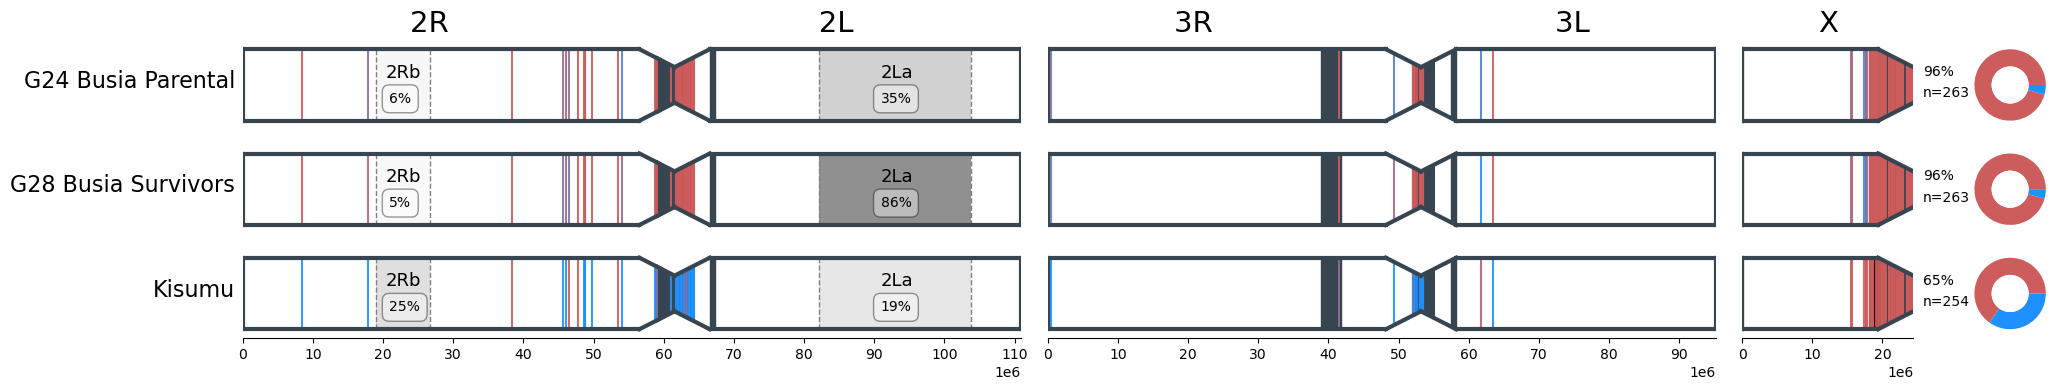

In [11]:
chrom2max = 61545105 + 49364325
chrom3max = 53200684 + 41963435
chromxmax = 24393108

f, ((ax0, ax1, ax2, ax10), (ax3, ax4, ax5, ax11), (ax6, ax7 , ax8, ax12)) = plt.subplots(3, 4, figsize=[21,4], gridspec_kw={'width_ratios': [chrom2max, chrom3max, chromxmax, 20_000_000]})
plotChromosomesAimsKaryos(ax0, ax1, ax2, 'BusiaParental', xaxis=False, title=True)
plotChromosomesAimsKaryos(ax3, ax4, ax5, 'BusiaSelected', xaxis=False)
plotChromosomesAimsKaryos(ax6, ax7, ax8, 'Kisumu', xaxis=True)
f.tight_layout()

plotDonut(ax10, aims, "BusiaParental", text=False, n=n_aims.loc["BusiaParental"][0])
plotDonut(ax11, aims, "BusiaSelected", text=False, n=n_aims.loc["BusiaSelected"][0])
plotDonut(ax12, aims, "Kisumu", text=False, n=n_aims.loc["Kisumu"][0])

f.tight_layout()
plt.show()

In [12]:
f.savefig('../../chromosome_karyo.svg', dpi=500, facecolor='white', transparent=False, edgecolor='none')

In [13]:
f.savefig('../../chromosome_karyo.pdf', dpi=500, facecolor='white', transparent=False, edgecolor='none')

Notes 

- Inversions can be colored based on karyo frequency
- Lines drawn for each aim, coloured by coluzzii/gamb/arab

In [216]:
pd.read_csv("../../results/variantAnalysis/SNPstats/totalSNPs.tsv", sep="\t", index_col=0).sum()

Total_SNPs    734269
dtype: int64

In [53]:
plt.rcParams['text.usetex'] = False

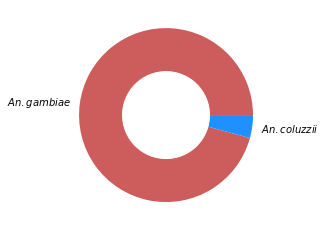

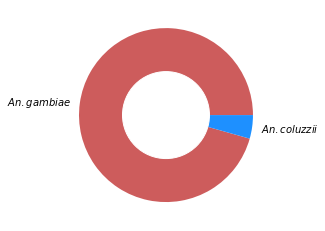

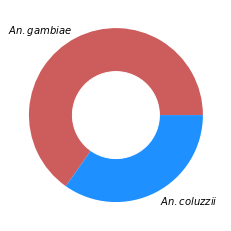

In [58]:
for group in metadata['treatment'].unique():
    data = aims.to_frame().reset_index().query(f"index == '{group}_gamb' | index == '{group}_colu'")
    plt.pie(data[0], labels = ['$\it{An. gambiae}$', '$\it{An. coluzzii}$'], colors=['indianred', 'dodgerblue'])
    circle = plt.Circle( (0,0), 0.5, color='white')
    p = plt.gcf()
    p.set_facecolor('white')
    p.gca().add_artist(circle)
    plt.show()

In [15]:
import itertools

In [19]:
comps = ['A', 'B', 'C', 'D']

for x, y in itertools.combinations(comps, 2):
    print(x,y)

print("")

A B
A C
A D
B C
B D
C D


In [26]:
for x, y in itertools.product(comps, comps):
    print(x, y)


A A
A B
A C
A D
B A
B B
B C
B D
C A
C B
C C
C D
D A
D B
D C
D D
